# LBF

In [2]:
!where python


c:\Users\propietari\anaconda3\python.exe
C:\Python313\python.exe
C:\Users\propietari\AppData\Local\Microsoft\WindowsApps\python.exe


In [70]:
import gymnasium as gym
import lbforaging 
import inspect
import matplotlib.pyplot as plt
from lbforaging.foraging.environment import ForagingEnv
import time
import matplotlib.pyplot as plt
import numpy as np
import re 

In [57]:
env_conf = "Foraging-8x8-2p-3f-v3"
env = gym.make(env_conf)
obs, __ = env.reset()

In [77]:
print(env.action_space)


Tuple(Discrete(6), Discrete(6))


In [60]:
print([name for name, _ in inspect.getmembers(ForagingEnv, inspect.isfunction)])
print(inspect.getsource(ForagingEnv._get_observation_space))
# print(inspect.getsource(ForagingEnv.render))
# print(obs)
# frame = env.render()

['__enter__', '__exit__', '__init__', '__str__', '_gen_valid_moves', '_get_info', '_get_observation_space', '_init_render', '_is_empty_location', '_is_valid_action', '_make_gym_obs', '_make_obs', '_transform_to_neighborhood', 'adjacent_food', 'adjacent_food_location', 'adjacent_players', 'close', 'get_valid_actions', 'get_wrapper_attr', 'has_wrapper_attr', 'neighborhood', 'render', 'reset', 'seed', 'set_wrapper_attr', 'spawn_food', 'spawn_players', 'step', 'test_gen_valid_moves', 'test_make_gym_obs']
    def _get_observation_space(self):
        """The Observation Space for each agent.
        - all of the board (board_size^2) with foods
        - player description (x, y, level)*player_count
        """
        player_levels = sorted(self.max_player_level)
        max_food_level = (
            max(self.max_food_level)
            if self.max_food_level is not None
            else sum(player_levels[:3])
        )
        if not self._grid_observation:
            field_x = self.field

## Environment parameters
*env = gym.make("Foraging<obs>-<x_size>x<y_size>-<n_agents>p-<food>f-<force_c>-v3")*

- *coop* indicates no agent can invididually collect an apple


### Observation Format

Each agent's observation contains 3 values per apple or agent: y position, x position and level. 

The structure of the observation array is:

- Apples: all apples first

- Self: the agent’s own information

- Other agents: the remaining agents

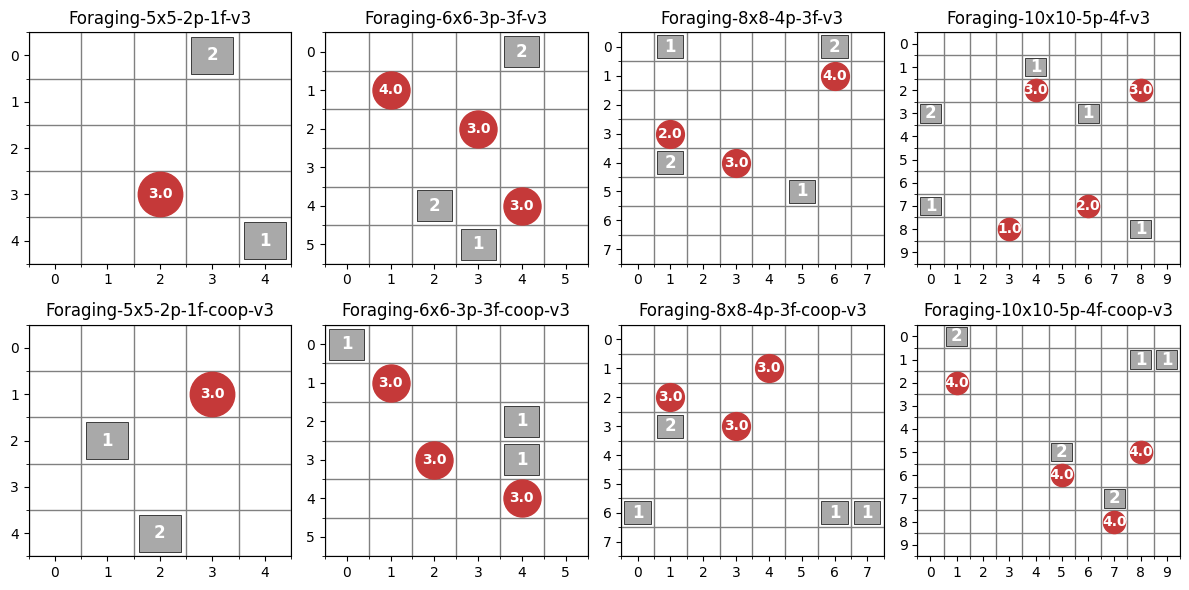

In [54]:
def plot_lbf_observation_tuple(ax, obs, env_conf):
    # Parse environment configuration
    conf = str(env_conf)
    match_size = re.search(r'(\d+)x(\d+)', conf)
    size_x, size_y = int(match_size.group(1)), int(match_size.group(2))
    
    match_agents = re.search(r'(\d+)p', conf)
    num_agents = int(match_agents.group(1))
    
    if isinstance(obs, tuple) and len(obs) > 0:
        obs_data = obs[0]
    else:
        obs_data = obs
    
    agent_idx = 3 * num_agents
    agents = obs_data[-agent_idx:]
    apples = obs_data[:-agent_idx]

    # Set limits and grid
    ax.set_xlim(-0.5, size_x - 0.5)
    ax.set_ylim(-0.5, size_y - 0.5)
    ax.set_xticks(np.arange(size_x))
    ax.set_yticks(np.arange(size_y))
    ax.set_xticks(np.arange(size_x + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(size_y + 1) - 0.5, minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0)
    
    # Plot apples
    num_apples = len(apples) // 3
    for i in range(num_apples):
        y = int(apples[3*i])
        x = int(apples[3*i + 1])
        level = apples[3*i + 2]
        ax.plot(x, y, marker='o', color="#C53939", markersize=20 * (8 / size_x), zorder=2)
        ax.text(x, y, f"{level}", color='white', ha='center', va='center', fontsize=10, fontweight='bold', zorder=3)

    # Plot agents
    for i in range(num_agents):
        y = int(agents[3*i])
        x = int(agents[3*i + 1])
        level = agents[3*i + 2]
        rect = plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, facecolor='darkgray', edgecolor='black', linewidth=0.5, zorder=2)
        ax.add_patch(rect)
        ax.text(x, y, f"{int(level)}", color='white', ha='center', va='center', fontsize=12, fontweight='bold', zorder=3)
    
    ax.set_title(env_conf)
    ax.invert_yaxis()

# Define multiple environment configurations
env_confs = [
    "Foraging-5x5-2p-1f-v3",
    "Foraging-6x6-3p-3f-v3",
    "Foraging-8x8-4p-3f-v3",
    "Foraging-10x10-5p-4f-v3",

    "Foraging-5x5-2p-1f-coop-v3",
    "Foraging-6x6-3p-3f-coop-v3",
    "Foraging-8x8-4p-3f-coop-v3",
    "Foraging-10x10-5p-4f-coop-v3",
]

n_rows = 2
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for ax, env_conf in zip(axs.flatten(), env_confs):
    env = gym.make(env_conf)
    obs, _ = env.reset()
    plot_lbf_observation_tuple(ax, obs, env_conf)

plt.tight_layout()
plt.show()
